In [1]:
from sys import stdout

import numpy as np
from numpy.polynomial.polynomial import Polynomial, polyfit, polyval
import sympy as sp
from sympy import symbols
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as _A  # imported for "side effects"
from IPython.display import display

import heisenberg

## The parameters: Generating set and n

In [2]:
S = [
    # Don't include 0 because it should give the same answer as counting all those 
    # np.array(( 0,  0,  0)),
    np.array(( 1,  0,  0)),
    np.array(( 0,  1,  0)),
    np.array(( 0,  0,  1)),
    np.array((-1,  0,  0)),
    np.array(( 0, -1,  0)),
    np.array(( 0,  0, -1)),
]

In [3]:
n = 9

Computing Heisenberg sums on S = [array([1, 0, 0]), array([0, 1, 0]), array([0, 0, 1]), array([-1,  0,  0]), array([ 0, -1,  0]), array([ 0,  0, -1])]...
showing h3


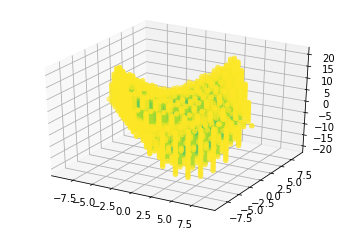

In [4]:
print("Computing Heisenberg sums on S = {}...".format(S))
p_n = list(heisenberg.compute_h3_pn_spheres(S, n))

plotted_h3 = heisenberg.PlotForm.from_spheres(p_n)
fig = plt.figure()
print("showing h3")
plotted_h3.plotme(fig)
plt.show(fig)

# Fitting a polynomial to the number of points
We'll generate, say, 8 numbers-of-points and then pick 5 (the first 5?) to fit it to, then test on the remaining numbers. To be sure.

In [5]:
P_k_sizes = [
    (
        k,
        len(
            set(
                tuple(point) for (point, i) in p_n if i <= k
            )
        )
    )
    for k in range(1, n+1)
]
P_k_sizes

[(1, 6),
 (2, 29),
 (3, 83),
 (4, 189),
 (5, 379),
 (6, 697),
 (7, 1199),
 (8, 1953),
 (9, 3039)]

In [6]:
# Now let's fit a polynomial to it
POLYNOMIAL_DEGREE = 4
fit_inputs = [k for (k, _) in P_k_sizes[0:POLYNOMIAL_DEGREE+1]]
fit_outputs = [size for (_, size) in P_k_sizes[0:POLYNOMIAL_DEGREE+1]]

p = Polynomial.fit(fit_inputs, fit_outputs, deg=POLYNOMIAL_DEGREE)
p.convert().coef[::-1]

array([ 0.45833333, -1.08333333, 10.54166667, -7.91666667,  4.        ])

In [7]:
cs = [sp.Rational(c).limit_denominator(10000000) for c in p.convert().coef[::-1]]
for c in cs:
    display(c)

11/24

-13/12

253/24

-95/12

4

In [8]:
def rectified_p(k: int) -> int:
    return (11*k**4 - 26*k**3 + 253*k**2 - 190*k + 96)//24

def dumb_p(k: int) -> int:
    return int(polyval(k, p.convert().coef))

def dumber_p(k: int) -> int:
    c = p.convert().coef.copy()
    print(c)
    c[-1] = 0
    c[-2] = 0
    print(c)
    return int(polyval(k, c))

In [9]:
# Testing...
evaller = dumb_p

for i in range(POLYNOMIAL_DEGREE + 1, n):
    k, size = P_k_sizes[i]
    predicted_size = evaller(k)
    if predicted_size != size:
        print(f"Polynomial was wrong for k = {k}! Bad! Expected {size}, got {predicted_size}!")
    else:
        print(f"({k}, size = {predicted_size} = {size})")

Polynomial was wrong for k = 6! Bad! Expected 697, got 696!
Polynomial was wrong for k = 7! Bad! Expected 1199, got 1194!
Polynomial was wrong for k = 8! Bad! Expected 1953, got 1938!
Polynomial was wrong for k = 9! Bad! Expected 3039, got 3004!


Hm, it doesn't fit, that's concerning. And it's not a rounding error, because I used the fitted polynomial directly. I didn't substitute rational coefficients. It's also off by more than one in three out of the four cases where it's wrong (testing with n = 9).

So it's not counted by a degree 4 polynomial.

Let's try degree 7.

In [148]:
# Now let's fit a polynomial to it
POLYNOMIAL_DEGREE = 7
fit_inputs = [k for (k, _) in P_k_sizes[0:POLYNOMIAL_DEGREE+1]]
fit_outputs = [size for (_, size) in P_k_sizes[0:POLYNOMIAL_DEGREE+1]]

p = Polynomial.fit(fit_inputs, fit_outputs, deg=POLYNOMIAL_DEGREE)
p.convert().coef[::-1]

array([ 1.98412698e-04, -6.94444444e-03,  1.01388889e-01, -2.98611111e-01,
        1.98888889e+00,  3.80555556e+00, -5.90476191e-01,  1.00000000e+00])

In [150]:
# Testing...
evaller = dumb_p

for i in range(POLYNOMIAL_DEGREE + 1, n):
    k, size = P_k_sizes[i]
    predicted_size = evaller(k)
    if predicted_size != size:
        print(f"Polynomial was wrong for k = {k}! Bad! Expected {size}, got {predicted_size}!")
    else:
        print(f"({k}, size = {predicted_size} = {size})")

(9, size = 3039 = 3039)


Oh no... it sure looks like this is naturally a degree 7 polynomial. Wish I had more datapoints to test that theory.

In [151]:
# cs = [sp.simplify(str(c), rational=True) for c in p.convert().coef[::-1]]
cs = [sp.Rational(c).limit_denominator(10000000) for c in p.convert().coef[::-1]]
for c in cs:
    display(c)

1/5040

-1/144

73/720

-43/144

179/90

137/36

-62/105

1

In [152]:
def rectified_p2(k: int) -> int:
    return (k**7 - 35*k**6 + 511*k**5 - 1505*k**4 + 10024*k**3 + 19180*k**2 - 2976*k + 5040)//5040

In [153]:
# Testing...
evaller = rectified_p2

for i in range(POLYNOMIAL_DEGREE + 1, n):
    k, size = P_k_sizes[i]
    predicted_size = evaller(k)
    if predicted_size != size:
        print(f"Polynomial was wrong for k = {k}! Bad! Expected {size}, got {predicted_size}!")
    else:
        print(f"({k}, size = {predicted_size} = {size})")

Polynomial was wrong for k = 9! Bad! Expected 3039, got 3040!


Oh gosh is this an even more gnarly polynomial? Is it degree 8 or 9? Is it even polynomial??? Is it a polynomial that's just really really gross the way the unsimplified version is?

Because without more datapoints to check it against and show it's eventually wrong, as far as I know it *could* just be a really nasty degree 7 polynomial. But I suspect that it's not polynomial.

Can we fit a rational function to it? That sounds hard. What if we fix the degree of the numerator and of the denominator to be fit? The problem is I'm not sure what degree to guess that it is. 4 and 3 seems like a reasonable conservative guess to try, but that requires $5 + 4 = 9$ datapoints to fit, I'd think, and that leaves me with none to test it on. Getting further datapoints would be gross. I could try 4 and 1 -- then I'd still have 2 datapoints left over to test it on, I think. $5 + 2 = 7$, $9 - 7 = 2$.

# Experiment: Using "quadrants"

```
Quadrant 1:  1  0  0;  0  1  0;  0  0  1
Quadrant 2: -1  0  0;  0 -1  0;  0  0  1
Quadrant 3:  1  0  0;  0 -1  0;  0  0 -1
Quadrant 4: -1  0  0;  0  1  0;  0  0 -1
```

$$
\begin{align*}
    S_1 &= \{(0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1)\} \\
    S_2 &= \{(0, 0, 0), (-1, 0, 0), (0, -1, 0), (0, 0, 1)\} \\
    S_3 &= \{(0, 0, 0), (1, 0, 0), (0, -1, 0), (0, 0, -1)\} \\
    S_4 &= \{(0, 0, 0), (-1, 0, 0), (0, 1, 0), (0, 0, -1)\}
\end{align*}
$$

In [30]:
S1 = [
    # Don't include 0 because it should give the same answer as counting all those 
    # np.array(( 0,  0,  0)),
    np.array(( 1,  0,  0)),
    np.array(( 0,  1,  0)),
    np.array(( 0,  0,  1)),
    np.array(( 0,  0, -1)),
]

S2 = [
    # Don't include 0 because it should give the same answer as counting all those 
    # np.array(( 0,  0,  0)),
    np.array((-1,  0,  0)),
    np.array(( 0, -1,  0)),
    np.array(( 0,  0,  1)),
    np.array(( 0,  0, -1)),
]

S3 = [
    # Don't include 0 because it should give the same answer as counting all those 
    # np.array(( 0,  0,  0)),
    np.array(( 1,  0,  0)),
    np.array(( 0, -1,  0)),
    np.array(( 0,  0, -1)),
    np.array(( 0,  0, -1)),
]

S4 = [
    # Don't include 0 because it should give the same answer as counting all those 
    # np.array(( 0,  0,  0)),
    np.array((-1,  0,  0)),
    np.array(( 0,  1,  0)),
    np.array(( 0,  0, -1)),
    np.array(( 0,  0, -1)),
]

n = 8

In [23]:
print("Computing Heisenberg sums on quadrant sets...")
p_S1_n = list(heisenberg.compute_h3_pn_spheres(S1, n))
p_S2_n = list(heisenberg.compute_h3_pn_spheres(S2, n))
p_S3_n = list(heisenberg.compute_h3_pn_spheres(S3, n))
p_S4_n = list(heisenberg.compute_h3_pn_spheres(S4, n))
p_Sis_n = (p_S1_n, p_S2_n, p_S3_n, p_S4_n)

Computing Heisenberg sums on quadrant sets...


Plotting quadrant things...


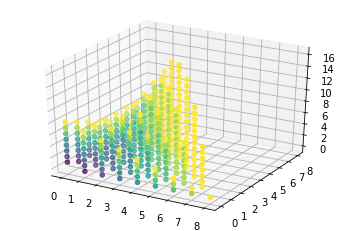

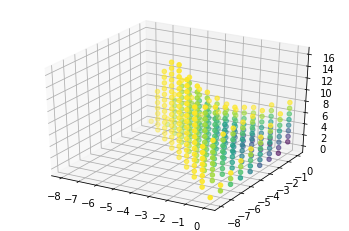

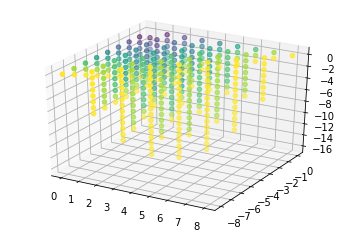

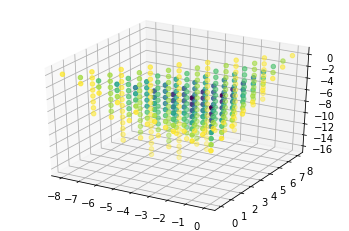

In [24]:
print("Plotting quadrant things...")
for p_Si_n in p_Sis_n:
    plotted_h3 = heisenberg.PlotForm.from_spheres(p_Si_n)
    fig = plt.figure()
    plotted_h3.plotme(fig)
    plt.show(fig)

In [25]:
p_Si_k_sizes = tuple(
    [(k, len(set(tuple(point) for (point, i) in p_Si_n if i <= k)))
     for k in range(1, n+1)]
    for p_Si_n in p_Sis_n)
p_Si_k_sizes

([(1, 3), (2, 10), (3, 24), (4, 49), (5, 90), (6, 153), (7, 245), (8, 374)],
 [(1, 3), (2, 10), (3, 24), (4, 49), (5, 90), (6, 153), (7, 245), (8, 374)],
 [(1, 3), (2, 10), (3, 24), (4, 49), (5, 90), (6, 153), (7, 245), (8, 374)],
 [(1, 3), (2, 10), (3, 24), (4, 49), (5, 90), (6, 153), (7, 245), (8, 374)])

Hm, looks like the sets all grow the exact same ways.

In [26]:
# Now let's fit a polynomial to it
POLYNOMIAL_DEGREE = 4
fit_inputs = [k for (k, _) in p_Si_k_sizes[0][0:POLYNOMIAL_DEGREE+1]]
fit_outputs = [size for (_, size) in p_Si_k_sizes[0][0:POLYNOMIAL_DEGREE+1]]

pol = Polynomial.fit(fit_inputs, fit_outputs, deg=POLYNOMIAL_DEGREE)
pol.convert().coef[::-1]

array([ 4.16666667e-02,  2.50000000e-01,  9.58333333e-01,  1.75000000e+00,
       -8.17124146e-14])

In [27]:
cs = [sp.Rational(c).limit_denominator(10000000) for c in pol.convert().coef[::-1]]
for c in cs:
    display(c)

1/24

1/4

23/24

7/4

0

In [28]:
def rectified_p(k: int) -> int:
    return (k**4 + 6*k**3 + 23*k**2 + 42*k + 0)//24

def dumb_p(k: int) -> int:
    return int(polyval(k, pol.convert().coef))

def dumber_p(k: int) -> int:
    c = p.convert().coef.copy()
    print(c)
    c[-1] = 0
    c[-2] = 0
    print(c)
    return int(polyval(k, c))

In [29]:
# Testing...
evaller = dumb_p

for i in range(POLYNOMIAL_DEGREE + 1, n):
    k, size = p_Si_k_sizes[0][i]
    predicted_size = evaller(k)
    if predicted_size != size:
        print(f"Polynomial was wrong for k = {k}! Bad! Expected {size}, got {predicted_size}!")
    else:
        print(f"({k}, size = {predicted_size} = {size})")

(6, size = 153 = 153)
(7, size = 245 = 245)
(8, size = 374 = 374)


**Note:** The sizes above are all too small by one because I don't add the zero sphere (containing only zero) in the computation code. Thus the actual counting polynomial has a constant term of 1. But that makes it identical to the tetrahedron counting polynomial and all of the counting functions should be identical to each other, so that works out nicely. But -- we clearly have cross-terms, because the octahedron isn't counted by four times that polynomial.

For reference, the counting polynomial for the tetrahedron (and for each quadrant tested above) is

$$
p(n) = \frac{1}{4!}n^4 + \frac{1}{4}n^3 + \frac{23}{24}n^2 + \frac{7}{4}n + 1 = |P_n(S)| = |P_n(S_i)|
$$

**Semi-related note:** Why things are bad in the octahedron:

Say we have some integer $y$, then $(-1, 0, 0)(0, y, 0)(1, 0, 0) = (0, y, -y)$.

If $y > 2$, then $(0, y, 0)(0, 0, -2) = (0, y, -2)$ has a higher (less negative) z-coordinate than $(0, y, -y)$.

# Experiment: Is this the right floor function?

I think I found the floor function for the half-octahedron

$$S = {0, x, y, z, -x, -z}.$$

I think it should be

$$
f(a, b) = \left\{\begin{align*}
    b\left(\min(a, 0) - \left\lfloor \frac{n - \left|a\right| - b}{2}\right\rfloor\right) - \left(\left(n - \left|a\right| - b\right) \mathrm{mod}\ 2\right) & \ \mathrm{for}\ b \lt 2 \\
    b \min(a, 0) - (n - |a| - b) & \ \mathrm{for}\ b \lt 2
\end{align*}\right\}
$$

In [2]:
S = [
    # Don't include 0 because it should give the same answer as counting all those 
    np.array(( 1,  0,  0)),  #  x
    np.array(( 0,  1,  0)),  #  y
    np.array(( 0,  0,  1)),  #  z
    np.array((-1,  0,  0)),  # -x
    np.array(( 0,  0, -1)),  # -z
]

n = 8

In [7]:
print("Computing Heisenberg sums on S = {}...".format(S))
p_n = list(heisenberg.compute_h3_pn_spheres(S, n))

Computing Heisenberg sums on S = [array([1, 0, 0]), array([0, 1, 0]), array([0, 0, 1]), array([-1,  0,  0]), array([ 0,  0, -1])]...


showing floor


<IPython.core.display.Javascript object>


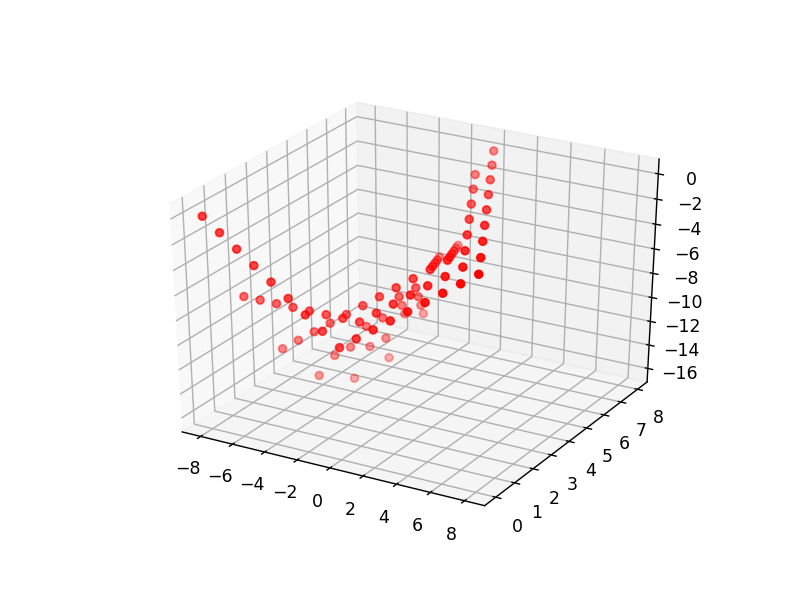

In [3]:
%matplotlib notebook

# Compute the floor
xs, ys = np.mgrid[-n:n+1:1, 0:n+1:1]
in_region = (np.abs(xs) + np.abs(ys)) <= n
xs, ys = xs[in_region], ys[in_region]

slack = n - np.abs(xs) - ys

# complete ver
zs = -ys*(-np.minimum(xs, 0) + (ys >= 2)*(slack // 2)) - (ys >= 2)*(slack % 2) - (ys < 2)*(slack)

# Show it
print("showing floor")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, color='r')
fig.show()

<IPython.core.display.Javascript object>


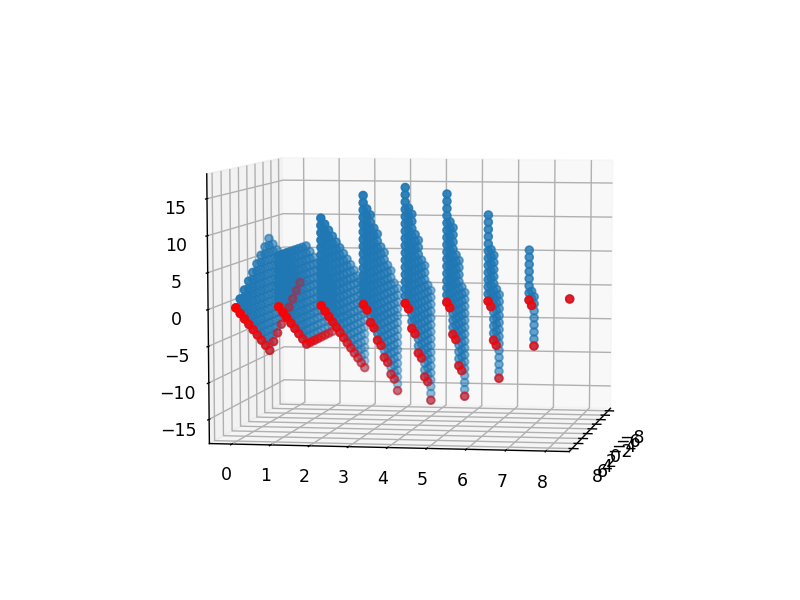

E:\prog\Miniconda3\envs\heis\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing arguments to show(), other than passing 'block' by keyword, is deprecated 3.1, and support for it will be removed in 3.3.
  # This is added back by InteractiveShellApp.init_path()


In [8]:
%matplotlib notebook

plotted_h3 = heisenberg.PlotForm.from_spheres(p_n)
p_n_xs, p_n_ys, p_n_zs = np.array(plotted_h3.xs), np.array(plotted_h3.ys), np.array(plotted_h3.zs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p_n_xs, p_n_ys, p_n_zs)
ax.scatter(xs, ys, zs, color='#FF0000FF')

plt.show(fig)

In [9]:
for p_n_x, p_n_y, p_n_z in zip(p_n_xs, p_n_ys, p_n_zs):
    for x, y, z in zip(xs, ys, zs):
        if (x <= 0) and (x == p_n_x) and (y == p_n_y) and (p_n_z < z):
            print("oh no, failed at x = {}, y = {}, z = {}, predicted floor = {}".format(x, y, p_n_z, z))

<IPython.core.display.Javascript object>


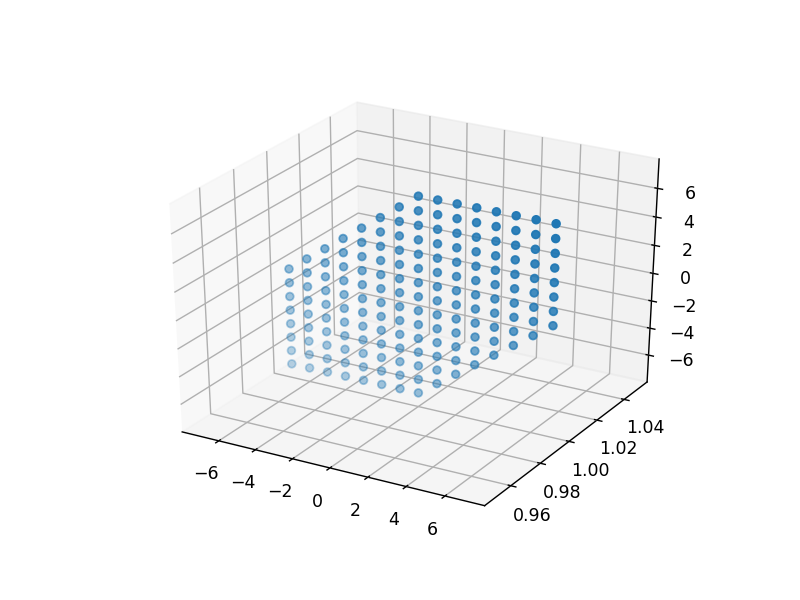

E:\prog\Miniconda3\envs\heis\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing arguments to show(), other than passing 'block' by keyword, is deprecated 3.1, and support for it will be removed in 3.3.
  app.launch_new_instance()


In [10]:
# get yz slices
%matplotlib notebook

C = 1

plotted_h3 = heisenberg.PlotForm.from_spheres(p_n)
p_n_xs, p_n_ys, p_n_zs = np.array(plotted_h3.xs), np.array(plotted_h3.ys), np.array(plotted_h3.zs)
y_is_C = (np.array(p_n_ys) == C)

p_n_xs, p_n_ys, p_n_zs = p_n_xs[y_is_C], p_n_ys[y_is_C], p_n_zs[y_is_C]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p_n_xs, p_n_ys, p_n_zs)

plt.show(fig)